# Querying news articles via DNA

8 news articles were ingested using the notebook, Demo_Article_Ingest. They deal with the 2024 presidential election and were published late on Nov 5 (election day) or on Nov 6 2024. 

The information is the direct output from OpenAI (GPT-4o), that has been encoded in RDF using the DNA ontology. The data is stored in a free Stardog Cloud endpoint. The OpenAI prompts and code to perform the ingest are available at https://github.com/ontoinsights/deep_narrative_analysis.

Analysis/visualization in the cells below is based on querying (using SPARQL) the RDF triples in Stardog, with a few additional calls to OpenAI to do topic/concept comparisons.

In [1]:
# Setup 
from dataclasses import dataclass
from dotenv import load_dotenv
from IPython.display import display, Image, Markdown
from matplotlib.ticker import MaxNLocator
from openai import OpenAI
from PIL import Image as PILImage

import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import panel as pn
import plotly.graph_objects as go
import plotly.io as pio
import requests
import stardog

load_dotenv()  # take environment variables from .env

sd_dna = 'dna'
sd_conn_details = {'endpoint': os.environ.get('STARDOG_ENDPOINT'),
                   'username': os.getenv('STARDOG_USER'),
                   'password': os.environ.get('STARDOG_PASSWORD')}
dna = 'urn:ontoinsights:dna'

openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI()

pn.extension('tabulator')

@dataclass
class Metadata:
    repository: str
    characterization: str
    source: str
    number_sents: int
    title: str

@dataclass
class Topics:
    source1: str
    source2: str

In [2]:
# Stardog connection
def stardog_connection():
    return stardog.Connection(sd_dna, **sd_conn_details)

conn = stardog_connection()

In [3]:
# Article sources
repo = 'election'

sources = ['Breitbart', 'Economist', 'Fox News', 'Huffington Post',
           'New York Times', 'USA Today', 'Wall Street Journal', 'Washington Times' ] 
center = ('Economist', 'Wall Street Journal')
conservative = ('Breitbart', 'Fox News', 'Washington Times')
liberal = ('Huffington Post', 'New York Times', 'USA Today', 'Washington Post')

# Prototype UI

## Bias Analysis of News Sources

## US presidential election results

### Analyzed articles from a mix of sources (all published Nov 5-6 2024)

###  

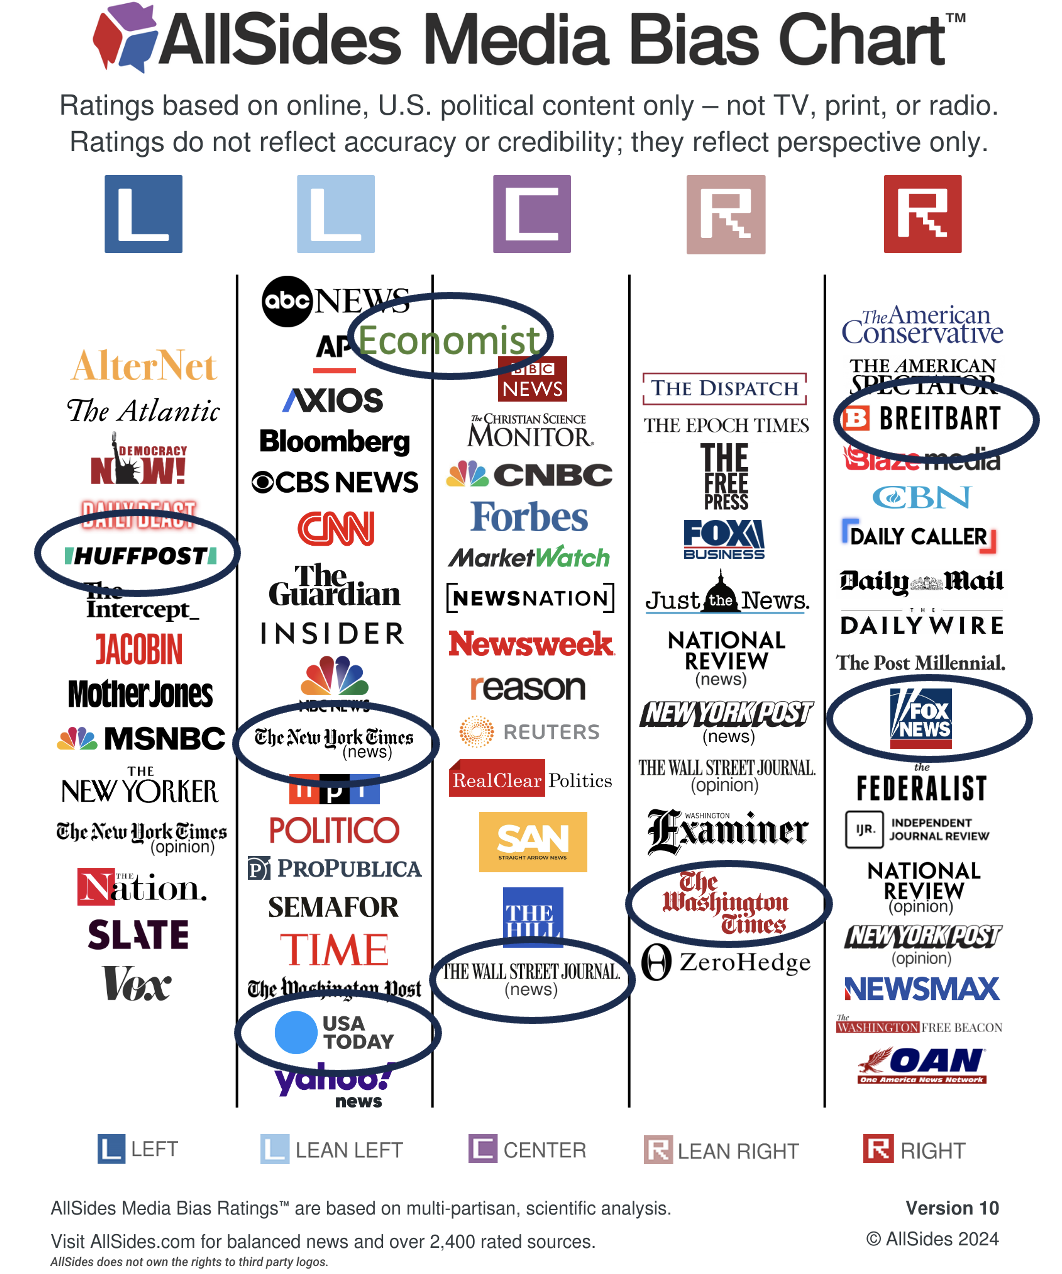

In [4]:
display(Markdown('## Bias Analysis of News Sources'))
display(Markdown('## US presidential election results'))
display(Markdown('### Analyzed articles from a mix of sources (all published Nov 5-6 2024)'))
display(Markdown('###  '))
image_path = "Media_bias.png"
# Get the original size of the image using PIL
original_image = PILImage.open(image_path)
original_width, original_height = original_image.size
# Calculate the new size (60% of the original)
new_width = int(original_width * 0.5)
new_height = int(original_height * 0.5)
# Display the resized image
display(Image(filename=image_path, width=new_width, height=new_height))

In [5]:
# Determine graph IRIs for the sources and get article metadata as Pandas dataframe
article_dict = dict()

response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={repo}')
narratives = response.json()['narratives']     # Array of narrative metadata dictionaries

for narr in narratives:
    source = narr['narrativeMetadata']['source']
    char_type = 'center' if source in center else ('conservative' if source in conservative else 'liberal')

    article_dict[narr['narrativeId']] = Metadata(repo, char_type, source, narr['numberOfSentences'],
                                                 narr['narrativeMetadata']['title'])

article_df = pd.DataFrame.from_dict(article_dict, orient='index')

In [6]:
display(Markdown('## Select a News Source to View Its Analysis'))
df_widget = pn.widgets.Tabulator(article_df, selectable='checkbox', show_index=False, pagination=None)
df_widget

## Select a News Source to View Its Analysis

Tabulator(hidden_columns=['index'], selectable='checkbox', show_index=False, value=         repository charac...)

# Article level statistics queries

Summary, sentiment, goals, subject areas and sentence-level stats

In [7]:
# Query definitions and some basic functions

# ?defGraph is replaced by f':{repo}_default, ?narrative is replaced by f':Narrative_{selected_narr_id}',
#    and ?narrGraph is replaced by f':{repo}_{selected_narr_id}'

goal_query = 'select ?goal where { graph ?defGraph {?narrative :narrative_goal ?goal} }'  
information_flow_query = 'select ?flow where { graph ?defGraph {?narrative :information_flow ?flow} }'  
subject_area_query = 'select ?area where { graph ?defGraph {?narrative :subject_area ?area} }'  
plot_query = 'select ?plot where { graph ?defGraph {?narrative :narrative_plotline ?plot} }'  
summary_query = 'select ?summary where { graph ?defGraph {?narrative :summary ?summary} }'   
topic_query = 'select ?topic where { graph ?defGraph {?narrative :topic ?topic} }'   
sentiment_query = 'select ?sentiment ?explanation where { ' \
                  '    graph ?defGraph {?narrative :sentiment ?sentiment ; :sentiment_explanation ?explanation} }'   
emotional_response_query = 'select ?conserv_int ?lib_int ?center_int where { ' \
                           '    graph ?defGraph {?narrative :interpretation_conservative ?conserv_int ; ' \
                           '                                :interpretation_liberal ?lib_int ; ' \
                           '                                :interpretation_neutral ?center_int} }'
sentence_query = 'select (COUNT(?sent) as ?cnt) (MIN(?grade) as ?min) (MAX(?grade) as ?max) (AVG(?grade) as ?avg) where { ' \
                 '    graph ?narrGraph {?sent a :Sentence ; :grade_level ?grade} }'
quotation_count_query = 'select (COUNT(?sent) as ?cnt) where { graph ?narrGraph {?sent a :Quote} }'

goals_dict = {
    'advocate': 'Promote or advocate for a cause, person or thing', 
    'analyze': 'Analyze an issue, event or trend in-depth, by breaking it down', 
    'describe-set': 'Describe/chronicle how a set of events, trends and conditions evolve over time', 
    'describe-single': 'Describe/focus on a single event, trend or condition', 
    'entertain': 'Entertain using humor and engaging content',    
    'establish-authority':'Establish authority by citing facts, statistics and quotes from experts', 
    'inspire': 'Inspire and motivate through uplifting stories, news, etc.', 
    'investigate': 'Uncover truths or corruption through detailed research',
    'life-story': 'Relate a personal narrative or life story'}

flows_dict = {
    'narrative/episodic': 'Presents interconnected stories/episodes, building toward a central theme and/or its resolution',
    'chronological': 'Follows a linear sequence of events, emphasizing decisive outcomes',
    'comparative': 'Contrasts multiple perspectives, events, people or outcomes to highlight similarities and differences',
    'thematic/multifaceted': 'Explores different aspects of a broader central subject, rather than being organized according to a timeline',
    'analytical': 'Focuses on explaining how and why, often incorporating data, detailed context and expert opinions',
    'argumentative': 'Builds a case step-by-step and presenting evidence, counterarguments and rebuttals in order to persuade a reader',
    'causal': 'Highlights cause-effect relationships; can be sequential but focuses on mechanisms, using logic and evidence', 
    'fragmented': 'Presents events outside of chronological order, emphasizing significant moments and events, or describing a journey of discovery',
    'speculative/forward-looking': 'Opens with a question, hypothesis, set of events or problem, and discusses potential/actual solutions or future implications',
    'historical context': 'Links current events to past occurrences, providing context and perspective',
    'cyclical': 'Ends the article by returning to the opening idea or quote',
    'spiral': 'Begins with a broad overview and then narrows down to specific details, returning to the main topic several times to deepen understanding',
    'summarized': 'Compresses details to high-level points, focusing on key takeaways without deep analysis',
    'inverted pyramid': 'Starts with most critical information and progressively provides less essential details',
    'question-answer': 'Presents a series of questions followed by answers to address reader inquiries'}

areas_dict = {
    'crime and law': 'Dealing with crime and criminal activities, legal cases, the justice system, organized crime, cybercrime, police brutality, police reform, fraud, embezzlement, prisons, and the correctional system',
    'economy and business': 'Dealing with financial markets, corporations and small businesses, earnings, mergers/acquisitions, trade, tariffs, jobs, economic trends, the stock market, employment/unemployment, consumer behavior, spending, taxation, real estate, cryptocurrency, and blockchain',
    'education': 'Dealing with education, schools, universities, learning, teaching and teachers, testing, and college admissions',
    'entertainment': 'Dealing with movies, TV, music, celebrities, cultural events, awards, books, gaming and performing arts',
    'environment and ecology': 'Dealing with weather, climate change, conservation, sustainability, deforestation, energy sources, pollution, wildlife protection, green technology, carbon emissions, waste management and environmental activism',
    'health': 'Dealing with medicines, pharmacology, diseases, symptoms, medical treatments, epidemics/pandemics, mental health, fitness, nutrition and diet, vaccines and public health',
    'human interest': 'Focusing on personal stories that inspire, amuse or emotionally connect',
    'lifestyle': 'Dealing with travel and travel destinations, food and drink, the fashion industry, personal style, home decor, interior design, hobbies, relationships and the family, aging, retirement and human interest', 
    'politics and international': 'Dealing with national and international politics - elections, campaigns, transfer of power, international conflict and war, diplomacy, terrorism, refugees and displaced persons, international aid and organizations (such as the UN and NATO), governance, political figures, partisanship, political polarization, polling, political appointments/nominations, and political activism',
    'science and technology': 'Dealing with space exploration, scientific discoveries, biotechnology, genetics, scientific debates, artificial intelligence, machine learning, cybersecurity, hardware, software, the tech industry, social media, and quantum computing',
    'sports': 'Dealing with sports leagues, tournaments, athletes, college sports, sports injuries, player transfers and trades, and sport fans'}

plots_dict = {
    'conflict and resolution': 'Reporting on conflicts (political, social, legal or military) and how they unfold/are resolved', 
    'rise and fall': 'Reporting on rise and fall (or fall and rise), focusing on ambition and consequences', 
    'overcoming the monster/heroic acts': 'Focusing on good vs. evil and/or survival, courage and resilience',
    'rags to riches': 'Documenting a rise from obscurity or hardness to greatness, wealth or happiness',
    'scandal and accountability': 'Investigating or exposing misconduct, corruption or ethical breaches, and/or seeking truth and transparency',
    'quest': 'Achieving significant goal(s) despite problems and obstacles along the way',
    'personal transformation': 'Undergoing personal transformation',
    'justice and revenge': 'Seeking justice or vengeance for wrongs done to someone'}

# Query execution and results return
def execute_query(query: str) -> list:
    query_results = conn.select(query, content_type='application/sparql-results+json')
    bindings = []
    if 'results' in query_results and 'bindings' in query_results['results']:
        bindings = query_results['results']['bindings']
    return bindings

# Stop cell execution
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

In [8]:
# Get selected row, execute article level queries and format results
try:
    selected_rows = df_widget.selection
    if len(selected_rows) != 1:
        raise Exception
except:
    print('To continue, please select a row from the table above.')
    raise StopExecution

article_id = article_df.iloc[selected_rows].index[0]
title = article_df.values[selected_rows[0], [4]]
source = article_df.values[selected_rows[0], [2]]

# Set query values
def_graph = f':{repo}_default'
narrative = f':Narrative_{article_id}'
graph = f':{repo}_{article_id}'

# Execute queries
bindings = execute_query(goal_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
goals = []
for binding in bindings:
    goals.append(goals_dict[binding['goal']['value']])

bindings = execute_query(information_flow_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
flows = []
for binding in bindings:
    flows.append(flows_dict[binding['flow']['value']])
    
bindings = execute_query(subject_area_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
areas = []
for binding in bindings:
    areas.append(areas_dict[binding['area']['value']])
    
bindings = execute_query(plot_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
plots = []
for binding in bindings:
    plots.append(plots_dict[binding['plot']['value']])

bindings = execute_query(summary_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
summary = '' if not bindings else bindings[0]['summary']['value']

bindings = execute_query(topic_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
topics = []
for binding in bindings:
    topics.append(binding['topic']['value'])

bindings = execute_query(sentiment_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
if not bindings:
    sentiment = explanation = ''
else:
    sentiment = bindings[0]['sentiment']['value']
    explanation = bindings[0]['explanation']['value']

bindings = execute_query(emotional_response_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
if not bindings:
    conservative_response = liberal_response = center_response = ''
else:
    conservative_response = bindings[0]['conserv_int']['value']
    liberal_response = bindings[0]['lib_int']['value']
    center_response = bindings[0]['center_int']['value']

bindings = execute_query(sentence_query.replace('?narrGraph', graph))
if not bindings:
    number_sentences = 1
    avg_grade = min_grade = max_grade = float(0)
else:
    number_sentences = int(bindings[0]['cnt']['value'])
    avg_grade = float(bindings[0]['avg']['value'])

bindings = execute_query(quotation_count_query.replace('?narrGraph', graph))
quotation_count = float(0) if not bindings else int(bindings[0]['cnt']['value'])

# Define the items for a bulleted list display of results and create/display the list
list_structure = {
    "Source": source,
    "Title": title,
    "Subject Areas": areas,
    "Goals": goals,
    "Information Flows": flows,
    "Plots": plots,
    "Summary": [summary],
    "Topics": topics,
    "Sentiment": [sentiment, explanation],
    "Responses": [f'Conservative: {conservative_response}', f'Liberal: {liberal_response}', f'Center: {center_response}'],
    "Grade Level": [f'Average: {str(round(avg_grade, 2))}'],
    "Number of Sentences": [article_df.values[selected_rows[0], [3][0]]],
    "Full Sentence Quotations": [f'Number: {quotation_count}', f'Percentage of all sentences: {str(round(quotation_count * 100/number_sentences, 2))}']
}

bulleted_list = ''
for main_item, sub_items in list_structure.items():
    bulleted_list += f'- **{main_item}**\n'       # Add main item
    for sub_item in sub_items:
        bulleted_list += f'  - {sub_item}\n'      # Add sub-item (indented by 2 spaces)

display(Markdown('## Detailed Article Analysis'))
display(Markdown(bulleted_list))

## Detailed Article Analysis

- **Source**
  - New York Times
- **Title**
  - Donald Trump Returns to Power, Ushering in New Era of Uncertainty
- **Subject Areas**
  - Dealing with national and international politics - elections, campaigns, transfer of power, international conflict and war, diplomacy, terrorism, refugees and displaced persons, international aid and organizations (such as the UN and NATO), governance, political figures, partisanship, political polarization, polling, political appointments/nominations, and political activism
  - Dealing with crime and criminal activities, legal cases, the justice system, organized crime, cybercrime, police brutality, police reform, fraud, embezzlement, prisons, and the correctional system
- **Goals**
  - Describe/chronicle how a set of events, trends and conditions evolve over time
  - Describe/focus on a single event, trend or condition
- **Information Flows**
  - Follows a linear sequence of events, emphasizing decisive outcomes
  - Contrasts multiple perspectives, events, people or outcomes to highlight similarities and differences
- **Plots**
  - Reporting on conflicts (political, social, legal or military) and how they unfold/are resolved
  - Reporting on rise and fall (or fall and rise), focusing on ambition and consequences
- **Summary**
  - The article chronicles Donald Trump's remarkable political comeback, winning the presidency for a second time in the 2024 U.S. Presidential Election. Despite facing numerous legal challenges, accusations of authoritarianism, and a deeply divided nation, Trump managed to defeat Vice President Kamala Harris. His campaign capitalized on economic and immigration concerns, promising radical changes to the political system. The election results showed a significant shift in voter support, with Trump flipping key states and Republicans gaining Senate seats. The article highlights the contentious nature of the campaign, the role of gender and racial issues, and the potential implications of Trump's presidency on American democracy.
- **Topics**
  - 2024 U.S. Presidential Election
  - Kamala Harris's campaign
  - Electoral College results
  - Donald Trump's political comeback
  - American political division
  - Trump's policies and promises
  - Republican Party dynamics
  - Gender and racial issues in politics
- **Sentiment**
  - neutral
  - The article presents a factual account of the election results and Trump's political journey without overtly positive or negative language. It highlights both the support and concerns surrounding Trump's presidency, providing a balanced view of the situation.
- **Responses**
  - Conservative: Conservatives may feel vindicated and optimistic about Trump's return to power, viewing it as a victory against the political establishment and a chance to implement their preferred policies.
  - Liberal: Liberals are likely to be concerned and disheartened by Trump's victory, fearing the potential erosion of democratic norms and the impact on social and political issues they care about.
  - Center: Neutral readers might be intrigued by the political dynamics and the implications of Trump's presidency, while also being concerned about the deepening political divide in the country.
- **Grade Level**
  - Average: 9.64
- **Number of Sentences**
  - 75
- **Full Sentence Quotations**
  - Number: 2
  - Percentage of all sentences: 2.67


# Article level statistics

In [9]:
# Function to produce histogram of counts for rhetorical devices or mentions, for a single article
def single_source_histogram(x_labels: list, counts: list, x_axis: str, y_axis: str):
    # Configure the histogram
    x_positions = np.arange(len(x_labels))
    plt.rcParams['figure.figsize'] = [12, 8] 
    fig, ax = plt.subplots()
    ax.bar(x_positions, counts, width=0.35, color='skyblue')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the bar heights
    bars = plt.bar(x_labels, counts, color='skyblue')
    for bar, x_label in zip(bars, x_labels):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{int(height)}', ha='center', fontsize='medium', fontweight='bold')

    # Label axes and x positions
    plt.xlabel(x_axis, fontweight='bold')
    plt.ylabel(y_axis, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha="right", fontweight='bold')  # Rotate for better readability

    plt.show()
    return

In [10]:
# Query for rhetorical device use and their counts
rhetorical_dict = {
    'ad baculum': 'An appeal to force or a threat of force in order to compel a conclusion', 
    'ad hominem': 'Use of wording that verbally demeans or attacks a person', 
    'ad populum': 'Reference to general or popular knowledge such as "the most popular xyz" or "everyone says xyz"', 
    'allusion': 'Reference to an historical/literary person, place or thing that has symbolic meaning', 
    'exceptionalism': 'Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary', 
    'expletive': 'Use of emphasis words, such as "in fact", "of course", "clearly" or "certainly"',           
    'imagery': 'Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader', 
    'invective': 'Use of ridicule, or angry or insulting language', 
    'loaded language': 'Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke ' \
                       'emotions and judgments', 
    'logos': 'Use of statistics and numbers', 
    'paralipsis': 'Indicating that little or nothing is said about a subject in order to bring attention to it, ' \
                  'such as saying "I will not mention their many crimes"', 
    'pathos': 'Wording that appeals to emotion such as fear or empathy',
    'rhetorical question/accusation': 'Asking rhetorical questions or making an explicit or implicit accusation'}

rhetorical_query = \
    'select ?device (COUNT(?sent) as ?cnt) where { ' \
    '    VALUES ?device {"ad baculum" "ad hominem" "ad populum" "allusion" "exceptionalism" "expletive" "imagery" ' \
    '                    "invective" "loaded language" "logos" "paralipsis" "pathos"} ' \
    '    {graph ?narrGraph {?sent a :Sentence ; :rhetorical_device ?device}} ' \
    '} GROUP BY ?device ORDER BY ?device'

## Use of Rhetorical Devices in New York Times

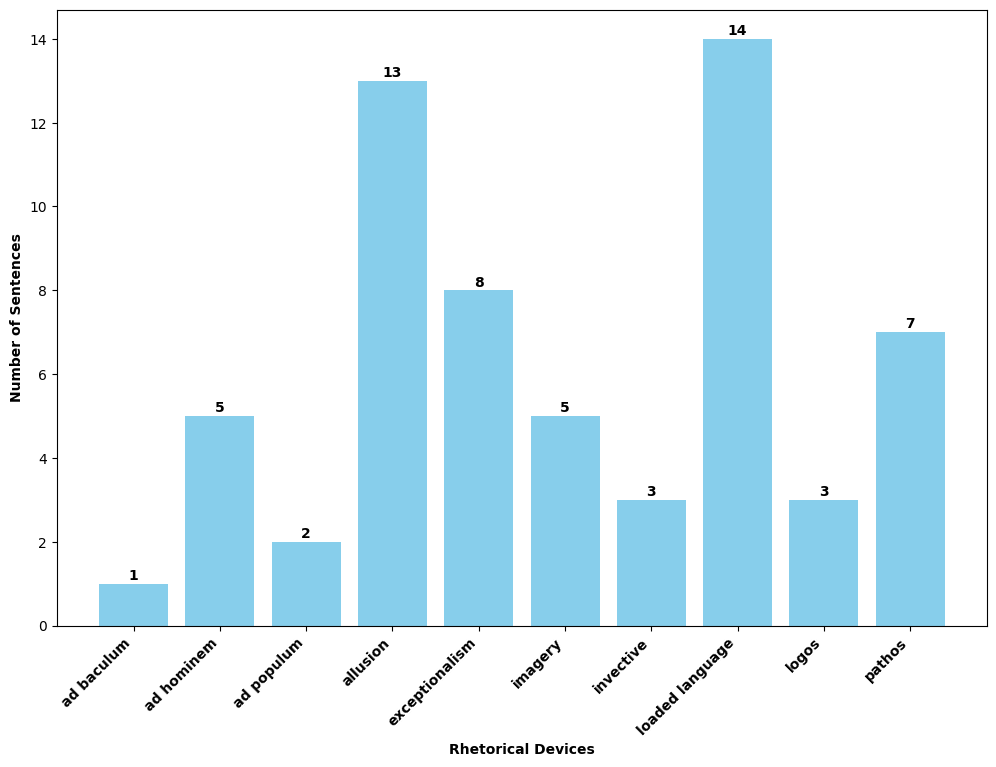

- **ad baculum**: An appeal to force or a threat of force in order to compel a conclusion
- **ad hominem**: Use of wording that verbally demeans or attacks a person
- **ad populum**: Reference to general or popular knowledge such as "the most popular xyz" or "everyone says xyz"
- **allusion**: Reference to an historical/literary person, place or thing that has symbolic meaning
- **exceptionalism**: Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary
- **imagery**: Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader
- **invective**: Use of ridicule, or angry or insulting language
- **loaded language**: Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke emotions and judgments
- **logos**: Use of statistics and numbers
- **pathos**: Wording that appeals to emotion such as fear or empathy


In [11]:
# Execute rhetorical device query and display results as a histogram
bindings = execute_query(rhetorical_query.replace('?narrGraph', graph))
devices = []
counts = []
for binding in bindings:
    devices.append(binding['device']['value'])
    counts.append(int(binding['cnt']['value']))

display(Markdown(f'## Use of Rhetorical Devices in {source[0]}'))
single_source_histogram(devices, counts, 'Rhetorical Devices', 'Number of Sentences')

# Show the rhetorical device definitions
bulleted_list = ''
for device in devices:
    bulleted_list += f'- **{device}**: {rhetorical_dict[device]}\n'  
display(Markdown(bulleted_list))

In [12]:
# Show where the article uses a device such as loaded language
specific_device = 'loaded language'
device_predicate = f":rhetorical_device_{specific_device.replace(' ', '_')}"
device_examples_query = 'select ?sent ?device_reason where { graph ?narrGraph {?s :text ?sent ; ?predicate ?device_reason}}'

bindings = execute_query(device_examples_query.replace('?narrGraph', graph).replace('?predicate', device_predicate))
bulleted_list = ''
for binding in bindings:
    bulleted_list += f"- {binding['device_reason']['value']}\n" 
    bulleted_list += f"  - Sentence text: {binding['sent']['value'].replace('$', '')}\n" 

display(Markdown(f'## Use of the "{specific_device.title()}" Device in {source[0]}'))
display(Markdown(bulleted_list))


## Use of the "Loaded Language" Device in New York Times

- The use of phrases like 'criminal conviction', 'indictments', 'assassin’s bullet', and 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
  - Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
- The phrase 'battering ram against the ruling establishment and the expert class of elites' uses loaded language with strong connotations to invoke emotions and judgments.
  - Sentence text: His defiant plans to upend the country’s political system held appeal to tens of millions of voters who feared that the American dream was drifting further from reach and who turned to Mr. Trump as a battering ram against the ruling establishment and the expert class of elites.
- The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
  - Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
- The term 'fascist' is loaded language with strong connotations that invoke emotions and judgments.
  - Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
- The use of words such as 'caustic', 'ugly', 'insult-filled', and 'bitter' are examples of loaded language, as they carry strong connotations and invoke emotional responses.
  - Sentence text: Then, he defeated Ms. Harris in a caustic 107-day crucible of a campaign that was ugly, insult-filled and bitter.
- The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments about the actions being described.
  - Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
- The phrase 'falsely claiming' uses loaded language with strong connotations, suggesting deception and invoking judgment.
  - Sentence text: He has refused to accept his loss four years ago, falsely claiming to this day that a second term was stolen from him in 2020.
- The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
  - Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
- The use of the words 'unhinged, unstable and unchecked' are loaded language with strong negative connotations that invoke emotions and judgments about Mr. Trump's potential behavior in a second term.
  - Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
- The phrase 'agent-of-chaos persona' uses loaded language with strong connotations that invoke emotions and judgments about the individual's character.
  - Sentence text: Instead, for millions of disillusioned Americans mistrustful of institutions and of a political system that they felt had failed them, his agent-of-chaos persona became an asset.
- The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
  - Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
- The terms 'stupid,' 'failed,' and 'dangerously liberal' are examples of loaded language, as they carry strong negative connotations and invoke emotional judgments.
  - Sentence text: He denigrated her as a “stupid person,” and called her “failed” and “dangerously liberal.”
- The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
  - Sentence text: Mr. Trump crushed his Republican rivals into submission.
- The word 'baited' is loaded language with strong connotations, suggesting manipulation and invoking emotions and judgments about the person's actions.
  - Sentence text: In September, she outmaneuvered and baited him at their only debate.


In [13]:
# Query for mentions of people, orgs, laws
mentions_query = \
    'select ?entity ?label (COUNT(?sent) as ?cnt) where { VALUES ?type {:OrganizationalEntity :Person :LawAndPolicy} ' \
    '    {graph ?defGraph {?entity a ?type ; :text ?label}} {graph ?narrGraph {?sent :mentions ?entity}} ' \
    '} GROUP BY ?entity ?label ORDER BY DESC(?cnt)'

## Entity Mentions in New York Times

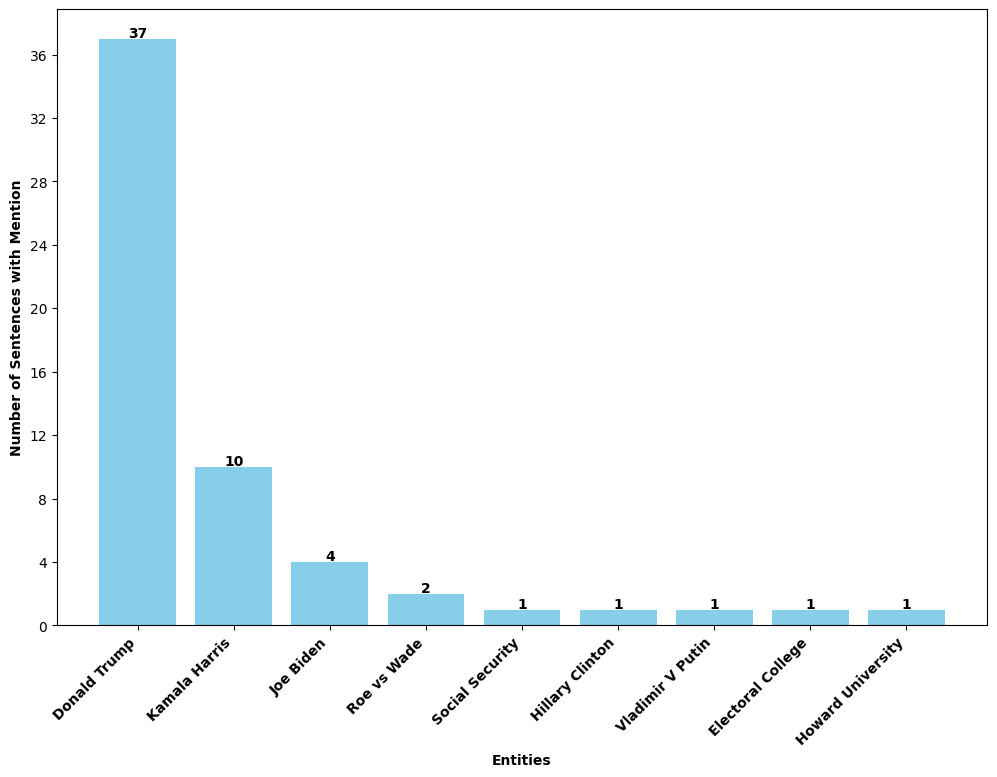

In [14]:
# Execute mentions query and display results as a histogram
bindings = execute_query(mentions_query.replace('?defGraph', def_graph).replace('?narrGraph', graph))
mentions = []
counts = []
for binding in bindings:
    mentions.append(binding['label']['value'])
    counts.append(int(binding['cnt']['value']))

display(Markdown(f'## Entity Mentions in {source[0]}'))
single_source_histogram(mentions, counts, 'Entities', 'Number of Sentences with Mention')

In [15]:
# Query for sentences that mention an entity and use a rhetorical device
mention = 'Donald Trump'
device = 'loaded language'
device_predicate = f":rhetorical_device_{device.replace(' ', '_')}"
sentence_mention_device_query = \
    'select ?sent_text ?device_reason where {' \
    '    {graph ?defGraph {?entity a ?type ; :text "?label"}} ' \
    '    {graph ?narrGraph {?sent :text ?sent_text ; :mentions ?entity ; ?predicate ?device_reason }} }'

In [16]:
# Execute mention/device query and display results
bindings = execute_query(sentence_mention_device_query.replace('?defGraph', def_graph).replace('?narrGraph', graph).
                        replace('?label', mention).replace('?predicate', device_predicate))
if not bindings:
    print("No full-sentence quotations were found in the article.")
    raise StopExecution

bulleted_list = ''
for binding in bindings:
    bulleted_list += f'- Sentence text: {binding["sent_text"]["value"].replace("$", "")}\n'  
    bulleted_list += f'  - {binding["device_reason"]["value"].replace("$", "")}\n'  

display(Markdown(f'## List of Sentences that Mention an Entity and Use {device.title()} in {source[0]}'))
display(Markdown(f'### Entity: {mention}'))
display(Markdown(f'### Device: {device}'))
display(Markdown(bulleted_list))         

## List of Sentences that Mention an Entity and Use Loaded Language in New York Times

### Entity: Donald Trump

### Device: loaded language

- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments about the actions being described.
- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments about the actions being described.
- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments about the actions being described.
- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong negative connotations that invoke emotions and judgments about Mr. Trump's potential behavior in a second term.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong negative connotations that invoke emotions and judgments about Mr. Trump's potential behavior in a second term.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong negative connotations that invoke emotions and judgments about Mr. Trump's potential behavior in a second term.
- Sentence text: His defiant plans to upend the country’s political system held appeal to tens of millions of voters who feared that the American dream was drifting further from reach and who turned to Mr. Trump as a battering ram against the ruling establishment and the expert class of elites.
  - The phrase 'battering ram against the ruling establishment and the expert class of elites' uses loaded language with strong connotations to invoke emotions and judgments.
- Sentence text: His defiant plans to upend the country’s political system held appeal to tens of millions of voters who feared that the American dream was drifting further from reach and who turned to Mr. Trump as a battering ram against the ruling establishment and the expert class of elites.
  - The phrase 'battering ram against the ruling establishment and the expert class of elites' uses loaded language with strong connotations to invoke emotions and judgments.
- Sentence text: His defiant plans to upend the country’s political system held appeal to tens of millions of voters who feared that the American dream was drifting further from reach and who turned to Mr. Trump as a battering ram against the ruling establishment and the expert class of elites.
  - The phrase 'battering ram against the ruling establishment and the expert class of elites' uses loaded language with strong connotations to invoke emotions and judgments.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of phrases like 'criminal conviction', 'indictments', 'assassin’s bullet', and 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of phrases like 'criminal conviction', 'indictments', 'assassin’s bullet', and 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of phrases like 'criminal conviction', 'indictments', 'assassin’s bullet', and 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The term 'fascist' is loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The term 'fascist' is loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The term 'fascist' is loaded language with strong connotations that invoke emotions and judgments.


In [17]:
# Query for complete sentence quotations and their attribution
quote_query = \
    'select ?quote ?entity (GROUP_CONCAT(?device;separator=", ") as ?devices) where { ' \
    '    graph ?narrGraph { ?sent a :Quote ; :text ?quote ; :attributed_to ?entity . ' \
    '                        OPTIONAL {?sent :rhetorical_device ?device}} ' \
    '} GROUP BY ?quote ?entity ORDER BY ?quote ?entity'

In [18]:
# Execute quotations query and display results
bindings = execute_query(quote_query.replace('?narrGraph', graph))
if not bindings:
    print("No full-sentence quotations were found in the article.")
    raise StopExecution

bulleted_list = ''
for binding in bindings:
    binding_quote = binding['quote']['value']
    if binding_quote.endswith(','):
        binding_quote = binding_quote[:-1]
    bulleted_list += f'- "{binding_quote}"\n'                      # Add quote as the main bullet item
    attribution = (binding['entity']['value']).split(':')[-1].replace('_', ' ')
    bulleted_list += f'  - Attribution: {attribution}\n'           # Add attribution sub-item
    if 'devices' in binding:
        bulleted_list += f'  - Rhetorical Devices: {binding["devices"]["value"]}\n' 

display(Markdown(f'## List of Full Quotations in {source[0]}'))
display(Markdown(bulleted_list))                      

## List of Full Quotations in New York Times

- "We are not going back"
  - Attribution: Kamala Harris
- "We overcame obstacles that nobody thought possible"
  - Attribution: Donald Trump
  - Rhetorical Devices: exceptionalism


## Sub-topic flow

In [19]:
# Query for concepts/events/conditions as defined by the DNA ontology and the involved/referenced entities
sub_topic_query = \
    'select distinct ?offset ?narrEventText ?type ?confidence ?negated ?negatedPred where { graph ?narrGraph ' \
    '    {?narrEvent a :NarrativeEvent ; :offset ?offset ; :text ?narrEventText ; :has_semantic ?event . ' \
    '     ?event a ?type . FILTER(?type != dna:PoliticsRelated) . ' \
    '     BIND(IRI(CONCAT("urn:ontoinsights:dna:", CONCAT("confidence-", STRAFTER(str(?type), "dna:")))) as ?confidencePred) . ' \
    '     BIND(IRI(CONCAT("urn:ontoinsights:dna:", CONCAT("negated-", STRAFTER(str(?type), "dna:")))) as ?negatedPred) . ' \
    '     OPTIONAL {?event ?confidencePred ?confidence} ' \
    '     OPTIONAL {?event ?negatedPred ?negated}} ' \
    '} ORDER BY ?offset'

# Get entity text
def get_detail_text(curr_details: str, binding: dict, relation: str, include_relation: bool) -> str:
    if relation not in binding:
        return curr_details
    if include_relation:
        text = f'{relation}: '
    else:
        text = ''
    if relation == 'type':
        text += binding['type']['value'].split(':')[-1]
    elif relation == 'negated' and binding['negated']['value']:
        text += binding['negatedPred']['value'].split('-')[1]
    else:
        text += binding[relation]['value'].replace('_', ' ')
    text = text if len(text) < 91 else f'{text[:90]} ...'
    if not curr_details:
        return text
    elif text not in curr_details:
        return f'{curr_details}; {text}'
    else:
        return curr_details

In [20]:
# Execute events/ontology mapping query and display results
pio.renderers.default = 'iframe'

bindings = execute_query(sub_topic_query.replace('?narrGraph', graph))
if not bindings:
    print("No sub-topics were found in the article.")
    raise StopExecution

sub_topics_dict = dict()
for binding in bindings:
    sub_topic_text = binding["narrEventText"]["value"]
    curr_details = ''
    if sub_topic_text in sub_topics_dict:
        curr_details = sub_topics_dict[sub_topic_text]
    if 'confidence' not in binding or int(binding['confidence']['value']) < 80:    # Discard bindings with confidence < 80%
        continue
    curr_details = get_detail_text(curr_details, binding, 'type', True)
    curr_details = get_detail_text(curr_details, binding, 'negated', True)
    sub_topics_dict[sub_topic_text] = curr_details

sub_topics = []
for topic_text, details in sub_topics_dict.items():
    rev_text = topic_text if len(topic_text) < 91 else f'{topic_text[:90]} ...'
    sub_topics.append({"name": rev_text, "details": details})

# Create a scatter plot for the concepts
fig = go.Figure()

# Add each concept as a point/trace on the vertical timeline
for i, topic in enumerate(sub_topics):
    fig.add_trace(go.Scatter(
        x=[1],  # Align all points vertically
        y=[i],  # Position of the event
        mode='markers+text',
        marker=dict(size=15, color='skyblue'),
        hoverinfo='text',
        hovertext=topic['details'] # Tooltip text
    ))

# Update layout for a vertical timeline
fig.update_layout(
    title=f'Event/Concept Progression in {source[0]}',
    xaxis=dict(visible=False),  # Hide the x-axis
    yaxis=dict(
        title="Sub-Topics",
        tickvals=list(range(len(sub_topics))),  # Set ticks for events
        ticktext=[topic['name'] for topic in sub_topics],  # Add event names as y-axis labels
        autorange='reversed'  # Reverse the y-axis for a top-to-bottom timeline
    ),
    showlegend=False,
    height=800,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Display the timeline
fig.show()

In [21]:
# Get event counts
def get_counts(counts_dict: dict, dict_key: str) -> int:
    if dict_key in counts_dict:
        return counts_dict[dict_key]
    else:
        return 0

counts_dict = dict()
for binding in bindings:
    if 'negated: ' in binding:
        event = f"!{get_detail_text('', binding, 'type', False)}"
    else:
        event = get_detail_text('', binding, 'type', False)
    count = get_counts(counts_dict, event) + 1
    counts_dict[event] = count    

## Event Counts in New York Times

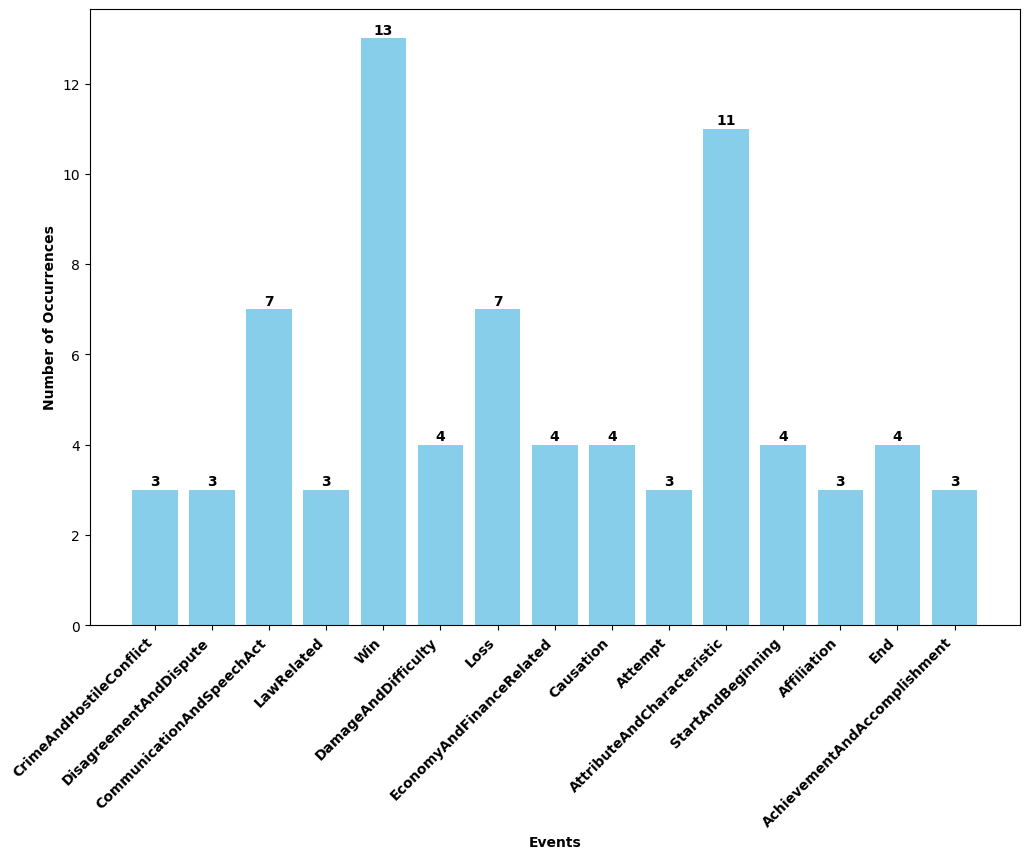

In [22]:
# Display histogram of counts
events = []
counts = []
for event, count in counts_dict.items():
    if count > 2:
        events.append(event)
        counts.append(count)

display(Markdown(f'## Event Counts in {source[0]}'))
single_source_histogram(events, counts, 'Events', 'Number of Occurrences')

## Article comparison

In [23]:
display(Markdown('## Select Two News Sources to Compare their Details Analysis'))
df_widget2 = pn.widgets.Tabulator(article_df, selectable='checkbox', show_index=False, pagination=None)
df_widget2

## Select Two News Sources to Compare their Details Analysis

Tabulator(hidden_columns=['index'], selectable='checkbox', show_index=False, value=         repository charac...)

In [24]:
# Get selected rows, and article metadata
try:
    selected_rows2 = df_widget2.selection
    if len(selected_rows2) != 2:
        raise Exception
except:
    print('To continue, please select two rows from the table above.')
    raise StopExecution

article_ids = [article_df.iloc[selected_rows2].index[0], article_df.iloc[selected_rows2].index[1]]
sources = article_df.values[selected_rows2, [2]]

narratives = [f':Narrative_{article_ids[0]}', f':Narrative_{article_ids[1]}']
graphs = [f'{repo}_{article_ids[0]}', f'{repo}_{article_ids[1]}']

In [25]:
# Function to produce histogram of counts for rhetorical devices or mentions, comparing two articles
def multi_source_histogram(x_set: set, source1_dict: dict, source2_dict: dict, x_axis: str, y_axis: str):
    # Sort set of all rhetorical devices or mentions
    sorted_x = list(sorted(x_set))
    # Organize counts by source
    count1_list = []
    count2_list = []
    for x in sorted_x:
        count1 = 0
        if x in source1_dict:
            count1 = source1_dict[x]
        count1_list.append(count1)
        count2 = 0
        if x in source2_dict:
            count2 = source2_dict[x]
        count2_list.append(count2)
        
    # Set positions for the bars
    x_positions = np.arange(len(sorted_x))  # Positions for categories
    width = 0.35  # Width of the bars
    
    # Create the histogram
    fig, ax = plt.subplots()
    bars1 = ax.bar(x_positions - width / 2, count1_list, width, label=sources[0], color="skyblue")
    bars2 = ax.bar(x_positions + width / 2, count2_list, width, label=sources[1], color="orange")
    
    # Add labels, title, and legend
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel(x_axis, fontweight='bold')
    ax.set_ylabel(y_axis, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sorted_x, rotation=45, ha="right", fontweight='bold')  # Rotate for better readability
    ax.legend()
    
    # Add counts on top of each bar
    for bar_group in [bars1, bars2]:
        for bar in bar_group:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{int(height)}', ha="center", va="bottom")
            
    plt.show()
    return

## Comparison of Rhetorical Devices in Multiple Articles

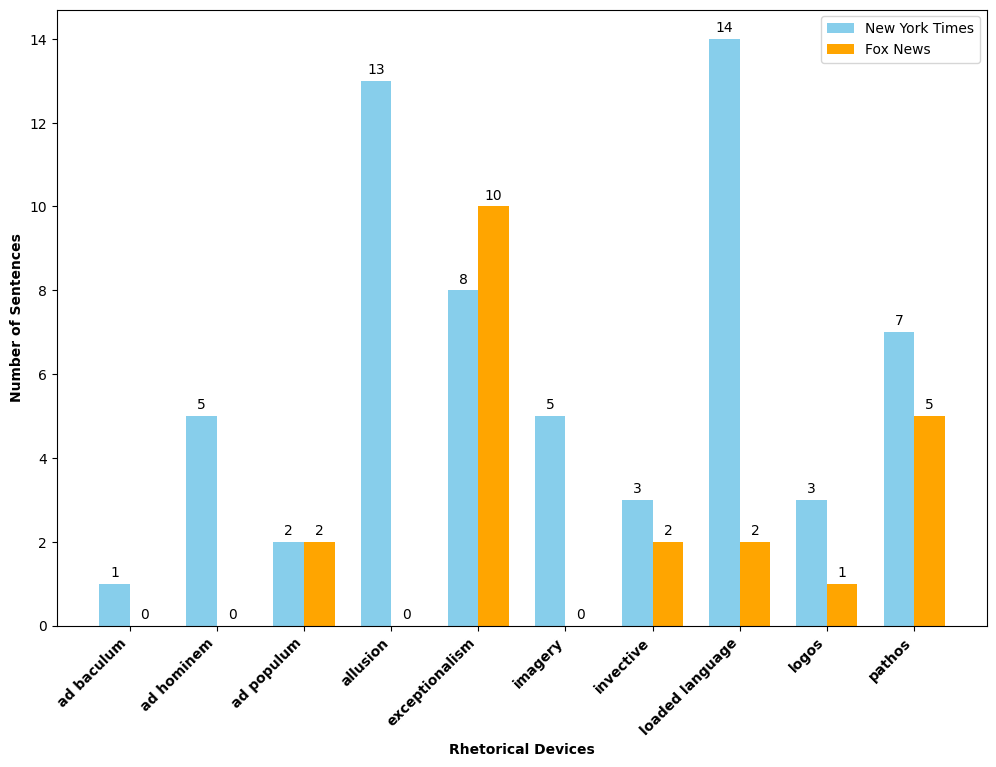

- pathos: Wording that appeals to emotion such as fear or empathy
- invective: Use of ridicule, or angry or insulting language
- ad baculum: An appeal to force or a threat of force in order to compel a conclusion
- exceptionalism: Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary
- allusion: Reference to an historical/literary person, place or thing that has symbolic meaning
- ad populum: Reference to general or popular knowledge such as "the most popular xyz" or "everyone says xyz"
- ad hominem: Use of wording that verbally demeans or attacks a person
- logos: Use of statistics and numbers
- imagery: Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader
- loaded language: Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke emotions and judgments


In [26]:
# Comparison of rhetorical devices, results displayed as histogram
devices = set()
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(rhetorical_query.replace('?narrGraph', graph))
    device_counts_dict = dict()
    for binding in bindings:
        device_counts_dict[binding['device']['value']] = int(binding['cnt']['value'])
        devices.add(binding['device']['value'])
    if index == 0:
        source1_dict = device_counts_dict
    else:
        source2_dict = device_counts_dict

display(Markdown('## Comparison of Rhetorical Devices in Multiple Articles'))
multi_source_histogram(devices, source1_dict, source2_dict, 'Rhetorical Devices', 'Number of Sentences')

# Show the rhetorical device definitions
bulleted_list = ''
for device in devices:
    bulleted_list += f'- {device}: {rhetorical_dict[device]}\n'  
display(Markdown(bulleted_list))

## Comparison of Entity Mentions in Multiple Articles

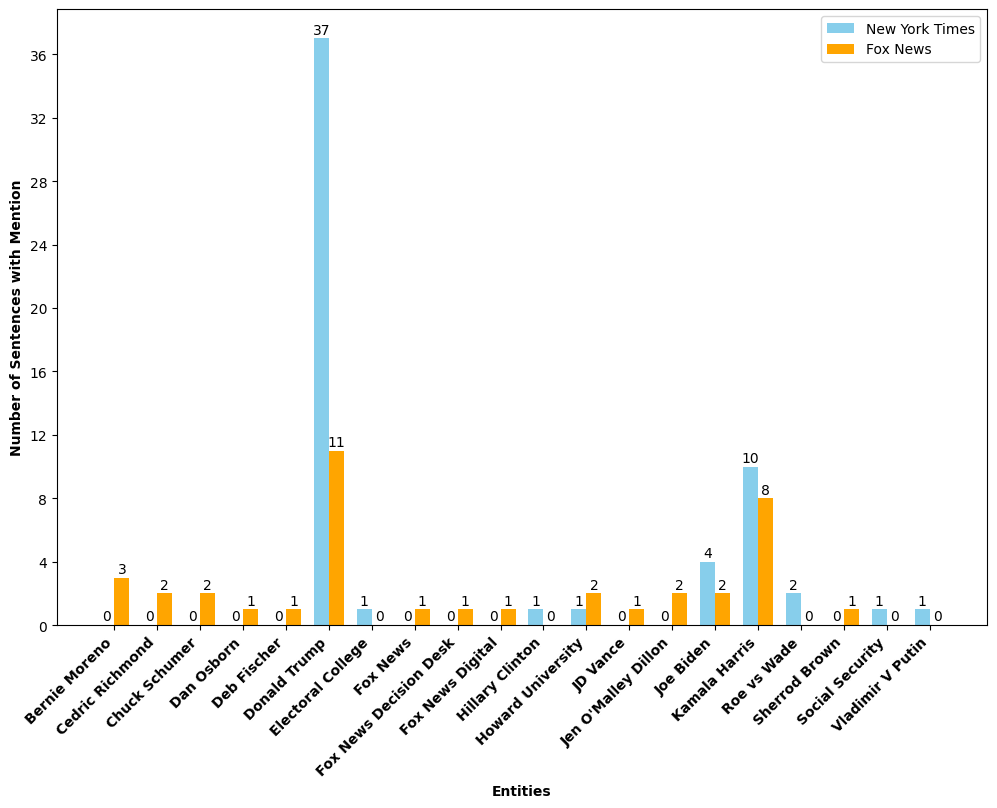

In [44]:
# Comparison of entity mentions, results displayed as histogram
def_graph = f':{repo}_default'
mentions = set()
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(mentions_query.replace('?defGraph', def_graph).replace('?narrGraph', graph))
    mention_counts_dict = dict()
    for binding in bindings:
        mention_counts_dict[binding['label']['value']] = int(binding['cnt']['value'])
        mentions.add(binding['label']['value'])
    if index == 0:
        source1_dict = mention_counts_dict
    else:
        source2_dict = mention_counts_dict

display(Markdown('## Comparison of Entity Mentions in Multiple Articles'))
multi_source_histogram(mentions, source1_dict, source2_dict, 'Entities', 'Number of Sentences with Mention')

In [27]:
# Get the high-level topic details from Stardog and use them in prompt to OpenAI to compare
stardog_connection()
for index, narrative in enumerate(narratives):
    bindings = execute_query(topic_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
    topic_index = 1
    list_strs = []
    topics = []
    for binding in bindings:
        topics.append(binding['topic']['value'])
        list_strs.append(f"{str(topic_index)}. {binding['topic']['value']}")
        topic_index += 1
    if index == 0:
        list1 = ' '.join(list_strs)
        topics1 = topics[:]
    else:
        list2 = ' '.join(list_strs)
        topics2 = topics[:]

In [28]:
# OpenAI request to align article topics
topic_prompt = \
    '<Task: You are ChatGPT, a large language model trained by OpenAI using the GPT-4 architecture, with expertise ' \
    'in linguistics and natural language processing (NLP). Your objective is to compare two lists of topics ' \
    'from two different news articles.> ' \
    '<Instructions: 1. Input Formats: a) You are provided with 2 lists of topics with each list coming from a different ' \
    'news article. Each topic in a list is numbered. The lists are separated by the string **. ' \
    '2: Topic Alignment: Your task is to examine the two lists of topics and indicate which topics are similar ' \
    'across the two lists, versus a topic being unique to a list. Topics in the two lists are indicated by their number.> ' \
    '<Inputs: News article 1: {list1} ** News article 2: {list2}> ' \
    '<Output: Return the response as a JSON object in the format: {"aligned_topics": [{"list1_topic": "int", "list2_topic": "int"}], ' \
    '"list1_unique_topics": ["int"], "list2_unique_topics": ["int"]}'                                                                       

def access_api(content: str) -> dict:
    try:
        response = client.chat.completions.create(
            model='gpt-4o',
            messages=[{"role": "user", "content": content}],
            response_format={"type": "json_object"},
            temperature=0.05, top_p=0.1)
        if "finish_reason='stop'" not in str(response):
            print(f'Non-stop finish response, {str(response)}, for content, {content}')
            return dict()
        resp_dict = json.loads(response.choices[0].message.content.replace('\n', ' '))
    except Exception as e:
        print(f'OpenAI exception or invalid response: {str(e)}')
        return dict()
    return resp_dict

In [29]:
# Get the topic comparisons from OpenAI and display them
topics_dict = access_api(topic_prompt.replace('{list1}', list1).replace('{list2}', list2))

comparison_dict = dict()
index = 0
for aligned in topics_dict['aligned_topics']:
    comparison_dict[index] = Topics(topics1[int(aligned['list1_topic']) - 1], topics2[int(aligned['list2_topic']) - 1])
    index += 1
for list1_unique in topics_dict['list1_unique_topics']:
    comparison_dict[index] = Topics(topics1[int(list1_unique) - 1], '')
    index += 1
for list2_unique in topics_dict['list2_unique_topics']:
    comparison_dict[index] = Topics('', topics2[int(list2_unique) - 1])
    index += 1

comparison_df = pd.DataFrame.from_dict(comparison_dict, orient='index')
display(Markdown(f'## High-Level Topic Alignment between the {sources[0]} and {sources[1]} Articles'))
display(Markdown(f'### {sources[0]} is "source1" and {sources[1]} is "source2"'))
df2_widget = pn.widgets.Tabulator(comparison_df, show_index=False, pagination=None)
df2_widget

## High-Level Topic Alignment between the New York Times and Fox News Articles

### New York Times is "source1" and Fox News is "source2"

Tabulator(hidden_columns=['index'], show_index=False, value=              ...)